In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D
from tensorflow.keras import Model
from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

Running the notebook `save_iris_dataset.ipynb` generated many files in `./gaze_dataset`.  
I manually split the samples into two folders: `./gaze_dataset/train` and `./gaze_dataset/test`.

#### Dataset Loading TRAIN samples


In [2]:
# Dataset params
num_classes = 100
SAVE_DIR_TRAIN = "./gaze_dataset/train"

x_train = []
y_train = []

for filename in os.listdir(SAVE_DIR_TRAIN):
    if not filename.endswith(".npy"):
        continue

    # filename: cell_{row}_{col}_{timestamp}.npy
    parts = filename[:-4].split("_")
    if len(parts) < 4 or parts[0] != "cell":
        continue  # skip no datasets files

    row = int(parts[1])
    col = int(parts[2])
    label = row * 10 + col

    filepath = os.path.join(SAVE_DIR_TRAIN, filename)
    data = np.load(filepath)

    # додаємо канал для Conv2D
    data = np.expand_dims(data, axis=-1)  # (H, W, 1)

    x_train.append(data)
    y_train.append(label)

x_train = np.array(x_train)
y_train = np.array(y_train)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

# One-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes)


x_train shape: (2320, 720, 1280, 1)
y_train shape: (2320,)


#### Dataset Loading TEST samples


In [3]:

SAVE_DIR_TEST = "./gaze_dataset/test"

x_test = []
y_test = []

for filename in os.listdir(SAVE_DIR_TEST):
    if not filename.endswith(".npy"):
        continue

    # filename: cell_{row}_{col}_{timestamp}.npy
    parts = filename[:-4].split("_")
    if len(parts) < 4 or parts[0] != "cell":
        continue  # skip no datasets files

    row = int(parts[1])
    col = int(parts[2])
    label = row * 10 + col

    filepath = os.path.join(SAVE_DIR_TEST, filename)
    data = np.load(filepath)

    # додаємо канал для Conv2D
    data = np.expand_dims(data, axis=-1)  # (H, W, 1)

    x_test.append(data)
    y_test.append(label)

x_test = np.array(x_test)
y_test = np.array(y_test)

print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

# One-hot encoding
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


x_test shape: (635, 720, 1280, 1)
y_test shape: (635,)


In [4]:
print('Train set:   ', len(y_train), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)

Train set:    2320 samples
Test set:     635 samples
Sample dims:  (2320, 720, 1280, 1)


#### Building the Classifier

We are going to build the same CNN classifier as before but note that we are using the softmax activation in the last layer (classification head).

In [5]:
size_h = x_train.shape[1]
size_w = x_train.shape[2]
print('Input shape: ',size_h,size_w)

inputs = Input(shape=(size_h, size_w, 1))

net = Conv2D(16, kernel_size=(3, 3), activation="relu")(inputs)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.2)(net)
net = Conv2D(33, kernel_size=(3, 3), activation="relu")(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.2)(net)
net = Conv2D(64, kernel_size=(3, 3), activation="relu")(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.2)(net)
net = Conv2D(32, kernel_size=(3, 3), activation="relu")(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.2)(net)
net = Flatten()(net)
net = Dropout(0.5)(net)
outputs = Dense(num_classes, activation="softmax")(net)

model = Model(inputs, outputs)
model.summary()

Input shape:  720 1280


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 720, 1280, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 718, 1278, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 359, 639, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 359, 639, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 357, 637, 33)   │         4,785 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 178, 318, 33)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 178, 318, 33)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 176, 316, 64)   │        19,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 88, 158, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 88, 158, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 86, 156, 32)    │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 43, 78, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 43, 78, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 107328)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 107328)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │    10,732,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,775,381 (41.10 MB)

 Trainable params: 10,775,381 (41.10 MB)

 Non-trainable params: 0 (0.00 B)

#### Training

Let's now compile and train the model. We will use the cross-entropy loss for this task. And note that we can use the built-in accuracy metric for monitoring the training.

In [6]:
epochs = 10
# batch_size = 128
batch_size = 32

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

start = time()
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
print('Elapsed time', time() - start)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 93s 856ms/step - accuracy: 0.3609 - loss: 3.4078 - val_accuracy: 0.7112 - val_loss: 0.7177
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 482ms/step - accuracy: 0.7668 - loss: 0.6588 - val_accuracy: 0.8276 - val_loss: 0.5088
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 487ms/step - accuracy: 0.8103 - loss: 0.4979 - val_accuracy: 0.8448 - val_loss: 0.5153
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 484ms/step - accuracy: 0.8519 - loss: 0.3930 - val_accuracy: 0.8405 - val_loss: 0.4445
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 482ms/step - accuracy: 0.8529 - loss: 0.4004 - val_accuracy: 0.8405 - val_loss: 0.4369
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 483ms/step - accuracy: 0.8690 - loss: 0.3229 - val_accuracy: 0.8621 - val_loss: 0.4355
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 484ms/step - accuracy: 0.8964 - loss: 0.2893 - val_accuracy: 0.8879 - val_loss: 0.3777
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 483ms/step - accuracy: 0.9057 - loss: 0.2620 - val_accu

Let's now plot the history to see the evolution of the training.

Train Acc      0.9295976758003235
Validation Acc 0.8534482717514038


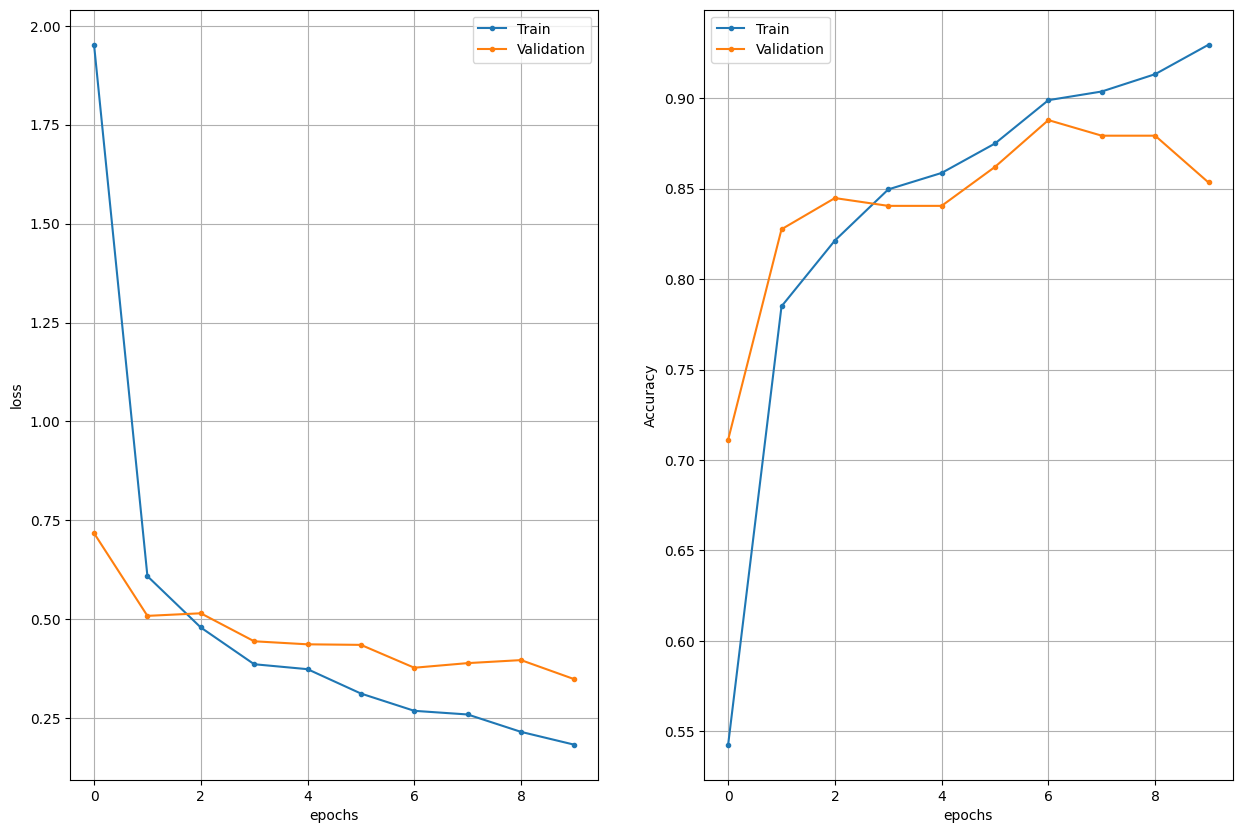

In [7]:
def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                               epochs, h['val_accuracy'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])

    print('Train Acc     ', h['accuracy'][-1])
    print('Validation Acc', h['val_accuracy'][-1])

plot_history(history)

In [8]:
y_true = np.argmax(y_test, axis=1)
y_pred = model.predict(x_test)

print('True', y_true[0:5])
print('Pred', np.argmax(y_pred[0:5, :], axis=1))

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 467ms/step
True [36 66 18 37 17]
Pred [36 66 18 35 17]


Evaluate model

In [9]:
ev = model.evaluate(x_test, y_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.8215 - loss: 0.5515


In [10]:
print('Test loss  ', ev[0])
print('Test metric', ev[1])

Test loss   0.5504927039146423
Test metric 0.8251968622207642
